In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import torch
import time

In [249]:
class GridWorld(object):

    def __init__(self):
        
        ### Attributes defining the Gridworld #######

        # Shape of the gridworld
        self.shape = (6,6)
        
        # Locations of the obstacles
        self.obstacle_locs = [(1,1),(3,1),(4,1),(4,2),(2,3),(4,4),(2,5)]
        
        # Locations for the absorbing states
        self.absorbing_locs = [(1,2),(4,3)]
        
        # Rewards for each of the absorbing states 
        self.special_rewards = [10, -100] # Corresponds to each of the absorbing_locs
        
        # Reward for all the other states
        self.default_reward = -1
        
        # Starting location 
        # This is only for the Dynamic Programming since the starting state doesn't matter
        self.starting_loc = (0,0)
        #### For Monte Carlo and Temporal Difference - use this to randomly select a starting state

        
        ## Actions used for Monte Carlo: N, E, S, W
        self.actions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        self.actions_indexed = [(1, 0, 0, 0), (0 ,1 ,0, 0), (0 ,0 ,1 ,0), (0, 0 ,0, 1)]
   
        # Action names
        self.action_names = ['N','E','S','W'] # Action 0 is 'N', 1 is 'E' and so on
        
        # Number of actions
        self.action_size = len(self.action_names)
        
        # Randomizing action results: [1 0 0 0] to no Noise in the action results.
        self.prob_moving = 0.4
#         self.prob_moving = 0.8
        self.prob_not_moving = (1-self.prob_moving)/3
        self.action_randomizing_array = [self.prob_moving, self.prob_not_moving, self.prob_not_moving, self.prob_not_moving]
        self.gamma = 0.35
#         self.gamma = 0.8
        ############################################
    

        #### Internal State  ####
        
        # Get attributes defining the world
        state_size, T, R, absorbing, locs = self.build_grid_world()
        
        # Number of valid states in the gridworld (there are 29 of them - 6x6 grid minus obstacles)
        self.state_size = state_size
        
        # Transition operator (3D tensor)
        self.T = T # T[st+1, st, a] gives the probability that action a will 
                   # transition state st to state st+1
        
        # Reward function (3D tensor)
        self.R = R # R[st+1, st, a ] gives the reward for transitioning to state
                   # st+1 from state st with action a
        
        # Absorbing states
        self.absorbing = absorbing
        
        # The locations of the valid states 
        self.locs = locs # State 0 is at the location self.locs[0] and so on
        
        # Number of the starting state
        self.starting_state = self.loc_to_state(self.starting_loc, locs);
        
        # Locating the initial state
        self.initial = np.zeros((1,len(locs)));
        self.initial[0,self.starting_state] = 1
        
        # Placing the walls on a bitmap
        self.walls = np.zeros(self.shape);
        for ob in self.obstacle_locs:
            self.walls[ob]=1
            
        # Placing the absorbers on a grid for illustration
        self.absorbers = np.zeros(self.shape)
        for ab in self.absorbing_locs:
            self.absorbers[ab] = -1
        
        # Placing the rewarders on a grid for illustration
        self.rewarders = np.zeros(self.shape)
        for i, rew in enumerate(self.absorbing_locs):
            self.rewarders[rew] = self.special_rewards[i]
        
        #Illustrating the grid world
        self.paint_maps()

        ################################
    
    

    ####### Getters ###########
    
    def get_transition_matrix(self):
        return self.T
    
    def get_reward_matrix(self):
        return self.R
    
    ########################


    
    ####### Methods #########
    
    def value_iteration(self, discount = 0.9, threshold = 0.0001):
        ## Slide 144 of the lecture notes for the algorithm ##
        
        # Transition and reward matrices, both are 3d tensors, c.f. internal state
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        # Initialisation
        epochs = 0
        delta = threshold # Setting value of delta to go through the first breaking condition
        V = np.zeros(self.state_size) # Initialise values at 0 for each state

        while delta >= threshold:
            epochs += 1 # Increment the epoch
            delta = 0 # Reinitialise delta value

            # For each state
            for state_idx in range(self.state_size):

                # If not an absorbing state
                if not(self.absorbing[0, state_idx]):
                  
                    # Store the previous value for that state
                    v = V[state_idx] 

                    # Compute Q value
                    Q = np.zeros(4) # Initialise with value 0
                    for state_idx_prime in range(self.state_size):
                        Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
                
                    # Set the new value to the maximum of Q
                    V[state_idx]= np.max(Q) 

                    # Compute the new delta
                    delta = max(delta, np.abs(v - V[state_idx]))
            

        # When the loop is finished, fill in the optimal policy
        optimal_policy = np.zeros((self.state_size, self.action_size)) # Initialisation

        # For each state
        for state_idx in range(self.state_size):
             
            # Compute Q value
            Q = np.zeros(4)
            for state_idx_prime in range(self.state_size):
                Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])
            
            # The action that maximises the Q value gets probability 1
            optimal_policy[state_idx, np.argmax(Q)] = 1 

        return optimal_policy, epochs


    #Policy improvement algorithm
    def policy_iteration(self, discount=0.9, threshold = 0.0001):
        ## Slide 139 of the lecture notes for pseudocode ##
        
        # Transition and reward matrices, both are 3d tensors, c.f. internal state
        T = self.get_transition_matrix()
        R = self.get_reward_matrix()
        
        # Initialisation
        policy = np.zeros((self.state_size, self.action_size)) # Vector of 0
        policy[:,0] = 1 # Initialise policy to choose action 1 systematically
        epochs = 0
        policy_stable = False # Condition to stop the main loop

        while not(policy_stable): 

            # Policy evaluation
            V, epochs_eval = self.policy_evaluation(policy, threshold, discount)
            epochs += epochs_eval # Increment epoch

            # Set the boolean to True, it will be set to False later if the policy prove unstable
            policy_stable = True

            # Policy iteration
            for state_idx in range(policy.shape[0]):
                
                # If not an absorbing state
                if not(self.absorbing[0,state_idx]):
                    
                    # Store the old action
                    old_action = np.argmax(policy[state_idx,:])
                
                    # Compute Q value
                    Q = np.zeros(4) # Initialise with value 0
                    for state_idx_prime in range(policy.shape[0]):
                        Q += T[state_idx_prime,state_idx,:] * (R[state_idx_prime,state_idx, :] + discount * V[state_idx_prime])

                    # Compute corresponding policy
                    new_policy = np.zeros(4)
                    new_policy[np.argmax(Q)] = 1  # The action that maximises the Q value gets probability 1
                    policy[state_idx] = new_policy
                
                    # Check if the policy has converged
                    if old_action != np.argmax(policy[state_idx]):
                        policy_stable = False
            
        return V, policy, epochs
                
        
    
    def policy_evaluation(self, policy, threshold, discount):
        
        # Make sure delta is bigger than the threshold to start with
        delta= 2*threshold
        
        #Get the reward and transition matrices
        R = self.get_reward_matrix()
        T = self.get_transition_matrix()
        
        # The value is initialised at 0
        V = np.zeros(policy.shape[0])
        # Make a deep copy of the value array to hold the update during the evaluation
        Vnew = np.copy(V)
        
        epoch = 0
        # While the Value has not yet converged do:
        while delta>threshold:
            epoch += 1
            for state_idx in range(policy.shape[0]):
                # If it is one of the absorbing states, ignore
                if(self.absorbing[0,state_idx]):
                    continue   
                
                # Accumulator variable for the Value of a state
                tmpV = 0
                for action_idx in range(policy.shape[1]):
                    # Accumulator variable for the State-Action Value
                    tmpQ = 0
                    for state_idx_prime in range(policy.shape[0]):
                        tmpQ = tmpQ + T[state_idx_prime,state_idx,action_idx] * (R[state_idx_prime,state_idx, action_idx] + discount * V[state_idx_prime])
                    
                    tmpV += policy[state_idx,action_idx] * tmpQ
                    
                # Update the value of the state
                Vnew[state_idx] = tmpV
            
            # After updating the values of all states, update the delta
            # Note: The below is our example way of computing delta.
            #       Other stopping criteria may be used (for instance mean squared error).
            #       We encourage you to explore different ways of computing delta to see 
            #       how it can influence outcomes.
            delta =  max(abs(Vnew-V))
            # and save the new value into the old
            V=np.copy(Vnew)
            
        return V, epoch
    

    ##  process to randomise an initial state
    def generate_final_grid(self):
        l1 = self.locs
        l2 = self.obstacle_locs
        l3 = self.absorbing_locs
        grid_w_absorbing = [x for x in l1 if x not in l2]
        final_grid = [x for x in grid_w_absorbing if x not in l3]
        final_grid = list(final_grid)
#         print(final_grid)
        return final_grid, grid_w_absorbing
    
    
#     def generate_trace(self):
    def generate_trace(self, policy_indexed, initState, final_grid, one_trace):
        
        # Turn the intial state into an index
        initState_idx = final_grid.index(initState)
#         print(initState_idx)
        trace = []
        action = []
#         print('initState:{}'.format(initState))
        
        while True:
            if (initState in self.absorbing_locs):
#                 print('final State is: {}'.format(initState))
                return trace
            
#             action = random.choice(self.actions)
            # The index of the action is the initial state index within the list of policies (29,1) which has a policy indexed from 0-3
            action_idx = policy_indexed[initState_idx]

            # Choose the optimal action as the action index of the original self.actions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
            action_optimal = self.actions[int(action_idx[0])]
            # insert the optimal action as the first action in the self.actions list
            self.actions.insert(0, grid.actions.pop(grid.actions.index(action_optimal)))

            # the index to choose is randomly chosen from the self.actions based on the action_randomizing array
            # this makes the action stochastic instead of deterministic
            idx = np.random.choice(len(self.actions),p = self.action_randomizing_array)
            # choose the action using the index
            action = self.actions[idx]

            # simply add the initial state and the action to get to the final state
            finalState = tuple(np.add(initState, action))

            # if the final state is outside of the grid or an obstacle then bounce back to the initial state and collect a reward of -1
            if -1 in list(finalState) or 6 in list(finalState) or finalState in grid.obstacle_locs :
#                 print('Outside grid or hit an obstacle so return to initial state')
                finalState = initState
                reward = self.default_reward
            ## This set of instructions checks what reward should be given => +10   
            elif finalState == self.absorbing_locs[0]:
#                 print('first self absorbing state has been entered')
                reward = self.special_rewards[0]
            ## This will be -100
            elif finalState == self.absorbing_locs[1]:
#                 print ('second self absorbing state has been entered')
                reward = self.special_rewards[1]
             #### Just move about if allowed and collect a reward of -1
            else:
#                 print('default state entered')
                reward = self.default_reward
            # append the trace to the list
            trace.append([initState, action, reward, finalState])
#             print(trace)
            # set the final state reached to the new initial state so that you can begin the next movement in the trace
            initState = finalState
            
            ##if we are using this function for Q-learning we only want one trace through therefore exit the function
            ## returning the trace here
            if one_trace == True:
                return trace

    
#     def first_visit_MC_pred(self, numIterations, policy_indexed):
#         #intialize
#         V = np.zeros((6, 6))
#         returns = {(i, j):list() for i in range(grid.state_size) for j in range(grid.state_size)}
# #         deltas = {(i, j):list() for i in range(grid.state_size) for j in range(grid.state_size)}
        
#         #Iterate over the trace creating function to average over the actions over many traces
#         for it in tqdm(range(numIterations)):
#             finalgrid, grid_w_absorbing = grid.generate_final_grid()
#             initState = random.choice(finalgrid)
#             Trace = grid.generate_trace(policy_indexed, initState,grid_w_absorbing,one_trace = False)
#             G = 0
# #             print('trace',Trace)
#             #Iterate through the action values from the traces
#             for i, step in enumerate(Trace[::-1]):# go backwards
# #                 print('step 2:',step[2]) # step[2] is the reward
#                 G = grid.gamma*G + step[2] # G = gamma*G + immediate reward
# #                 print('step 0:',step[0]) # step[0] is the intitial state
# #                 print('step 1:',step[1]) # step[1] is the action
#                 if step[0] not in [x[0] for x in Trace[::-1][len(Trace)-i:]]: # if initial state is not in the trace already
#                     idx = (step[0][0], step[0][1]) # idx is the intitial state
# #                     print('idx',idx)
#                     returns[idx].append(G) # append G to the returns at the intitial states index
# #                     print('returns',returns)
#                     newValue = np.average(returns[idx]) # new value is the average of the indexed return
# #                     print('new value', newValue)
#                     #deltas[idx[0], idx[1]].append(np.abs(V[idx[0], idx[1]]-newValue))
#                     V[idx[0], idx[1]] = newValue # set the new value to the value function at the intial states position
                    
#         return V
######THIS FUNCTION NEEDS WORK

    def first_visit_MC_pred(self, episodes, policy_indexed,alpha):
        #intialize
#         V = np.zeros((6, 6))
        V = np.zeros((29,1))
#         returns = {(i, j):list() for i in range(grid.state_size) for j in range(grid.state_size)}
#         returns = []
    
        #Iterate over the trace creating function to average over the actions over many traces
        for it in tqdm(range(episodes)):
            final_grid, grid_w_absorbing = grid.generate_final_grid()
            initState = random.choice(final_grid)
            # check whether youre meant to find the whole trace -  i think you are
#             Trace = grid.generate_trace(policy_indexed, initState,final_grid,one_trace = False)
            G = 0
            Trace = grid.generate_trace(policy_indexed, initState,final_grid,one_trace = False)
#             print('trace',Trace)
            #Iterate through the action values from the traces
            # this is using a mixture of two algorithms i believe
            for i, step in enumerate(Trace[::-1]):# go backwards
#                 print('step 2:',step[2]) # step[2] is the reward
                G = grid.gamma*G + step[2] # G = gamma*G + immediate reward
#                 print('step 0:',step[0]) # step[0] is the intitial state
#                 print('step 1:',step[1]) # step[1] is the action
                if step[0] not in [x[0] for x in Trace[::-1][len(Trace)-i:]]: # if initial state is not in the trace already
                    state= (step[0][0], step[0][1]) 
                    state_idx = grid_w_absorbing.index(state)
                
#                     returns[state_idx].append(G) # append G to the returns at the intitial states index
#                     print('returns',returns)
                    # Because this is within for loop it should be updating on each step through the
                    # trace - see slide 165
                    V[state_idx] = V[state_idx] + alpha*(G-(V[state_idx]))
                    
        return V
    
    def TD_value_estimation(self, episodes, policy_indexed,alpha):
        
        #intialize V to arbitrary value
        V = np.zeros((29,1))

        #Iterate over all the episodes
        for it in tqdm(range(episodes)):
            # initialise a random starting state
            final_grid, grid_w_absorbing = grid.generate_final_grid()
            initState = random.choice(final_grid)
            # while not an absorbing state, repeat all of this
            while True:
                # create a single step trace i.e. a action chosen using the policy
                # at state s to observe the reward and next state
                Trace = grid.generate_trace(policy_indexed, initState,final_grid,one_trace = True)
#             print('trace',Trace)
                # calling the variables by there names
                state,action,reward,state_prime = Trace[0]
                # indexing the variables
                state_idx = grid_w_absorbing.index(tuple(state))
                state_prime_idx = grid_w_absorbing.index(tuple(state_prime))
                # delta = r + gamma*V[s']-V[s]
                delta = reward + grid.gamma*V[state_prime_idx]-V[state_idx]
                #v[s] = V[s]+alpha*delta
                V[state_idx] += alpha*delta
                initState = state_prime
                if initState in self.absorbing_locs:
                    break
                    
        return V
    
    # epsilon greedy function
    def make_epsilon_greedy_policy(self,epsilon, Q):
        
        # set A => array of 4 lots of epsilon/4
        A= np.ones(4)*(epsilon/4)
        # A_set will be filled as required below
        A_set = np.zeros((29,4))
        # similarly the policy indexed from 0-3 will be filled below
        policy_indexed = np.zeros((29,1))
        
        #iterate over the state indexes
        for state_idx in range(len(Q)):
            # this is the greedy choice that chooses the action as to maximise Q
            best_action = np.argmax(Q[state_idx])
            #print("np.argmax(Q[state_idx]) is ", best_action)
            # set the whole state indexed row of A_set to A = epsilon/4
            A_set[state_idx] = A
            # set the best action index to epsilon/4 + 1 - epsilon
            A_set[state_idx][best_action] += (1.0 - epsilon)
#             print('A set:',A_set)
            #Now when choosing the policy index, randomly choose based on the epsilon greedy policy function
            policy_indexed[state_idx] = np.random.choice((0,1,2,3),p=tuple(A_set[state_idx]))
#             print('policy',policy)
        return policy_indexed

    def monte_carlo_e_soft(self, episodes, epsilon, alpha):
        
        # Empty dictionary for storing rewards for each state-action pair and the returns that get filled below
        Q = np.zeros((29, 4)) 
#         returns = np.zeros((29,4))
        # use the generate grid function to obtain the two grids as arrays - final_grid and grid_w_absorbing_states
        final_grid,grid_w_absorbing = grid.generate_final_grid()
        # Initialise to assess the algorithms learning capabilities
        reward_agent_final = []
        reward_agent = 0
        
        for it in tqdm(range(episodes)): # Looping through episodes
            
            G = 0 # Store cumulative reward in G (initialized at 0)
#             print('Q:',Q)
            policy_indexed = grid.make_epsilon_greedy_policy(epsilon, Q)
            # Set an intial state for each trace
#             initState = random.choice(final_grid)
            initState = (0,0)
            # Obtain a trace with the epsilon greedy policy and random initial state
            Trace = grid.generate_trace(policy_indexed, initState,final_grid, one_trace = False)
            
#             print(Trace)
            # find the backwards discounted total return to assess the algorithm
            for i, step in enumerate(Trace[::-1]):
                reward_agent = grid.gamma*reward_agent+step[2] # iterating through backwards means we propogate the gamma
                # term through from the end => final reward * gamma^n
            
            #this stores the total discounted reward the agent receives for one trace/episode
            reward_agent_final.append(reward_agent)
            
            for i, step in enumerate(Trace):# go forwards through the trace calculating the reward for state action pairs
#                 print('step 2:',step[2]) # step[2] is the reward
                # discounted reward on timestep
                G = grid.gamma*G + step[2] # G = gamma*G + immediate reward
#                 print('step 0:',step[0]) # step[0] is the intitial state
#                 print('step 1:',step[1]) # step[1] is the action

                # if initial state action to next state transition has not been followed before then proceed
                # i.e. this is first visit MC
                if step[0] not in [x[0] for x in Trace[::-1][len(Trace)-i:]]: 
                    state = (step[0][0], step[0][1])
                    # state_idx is the intitial state index from the with absorbing states: this is important for indexing
                    # in the returns and Q function
                    state_idx = grid_w_absorbing.index(tuple(state))
                    # the action from the trace
                    action = (step[1][0], step[1][1])
                    # the action index from grid.actions from 0-3
                    action_idx = grid.actions.index(action)# action index
        #                     print('state idx',state_idx)
        #                     print('action index:',action_idx)
        #                     print('returns',returns)
#                     # add G as the entry for a particular state action pair - SURELY THIS IS JUST THE SAME AS 
#                     # MINUSING G FROM BELOW WHATTTTT?
#                     returns[state_idx][action_idx] = G 
        #                     print('returns',returns)

                             # Average reward across episodes with factor alpha
#                     Q[state_idx][action_idx] = Q[state_idx][action_idx] + alpha * (returns[state_idx][action_idx] - Q[state_idx][action_idx])  
                    Q[state_idx][action_idx] = Q[state_idx][action_idx] + alpha * (G - Q[state_idx][action_idx])  

        
        return Q, policy_indexed,reward_agent_final
    
     
    def Q_learning_TD_function(self, alpha, epsilon, episodes):
        
        #Initialisation
        Q = np.zeros((29,4))
        final_grid,grid_w_absorbing = grid.generate_final_grid()
        reward_agent_final = []
        reward_agent = 0
        
        #main for loop
        for it in tqdm(range(episodes)):
            #initState randomised
            reward_agent_final.append(reward_agent)
            reward_agent = 0
            initState = random.choice(final_grid)
            initState_idx = final_grid.index(initState)
            while True: # Only exit when we get to a terminal state
                #find the epsilson greedy policy given Q
                policy_indexed = grid.make_epsilon_greedy_policy(epsilon, Q)
                # generate a single trace given the state and policy
                trace = grid.generate_trace(policy_indexed, initState, final_grid, one_trace = True)
                # this names the various outputs of 'trace'
                state, action, reward, state_prime = trace[0] 
                # this indexes the state, action, and next state
                state_idx = grid_w_absorbing.index(tuple(state))
                action_idx = grid.actions.index(action)
                state_prime_idx = grid_w_absorbing.index(tuple(state_prime))
                #now calculate our Q-value based on the previous value, the immediate reward of going to the
                # next state, a discounted value of (the maximum value of the next state and minus the current state)
                # this is called: Q-learning off policy control
                Q[state_idx][action_idx]= Q[state_idx][action_idx]+alpha*(reward + grid.gamma*np.argmax(Q[state_prime_idx])- 
                                                                          Q[state_idx][action_idx])
                initState = state_prime
                reward_agent+= reward
                if initState in self.absorbing_locs:
#                     print('final State is: {}'.format(initState))
                    break
            
        return Q, policy_indexed, reward_agent_final
                    
    def SARSA_learning_TD_function(self, alpha, epsilon, episodes):
        
        #Initialisation
        Q = np.zeros((29,4))
        final_grid,grid_w_absorbing = grid.generate_final_grid()
        reward_agent_final = []
        reward_agent = 0
        
        #main for loop
        for it in tqdm(range(episodes)):
            #initState randomised
            reward_agent_final.append(reward_agent)
            reward_agent = 0
            #initState randomised
            initState = random.choice(final_grid)
            initState_idx = final_grid.index(initState)
            #find the epsilson greedy policy given Q
            policy_indexed = grid.make_epsilon_greedy_policy(epsilon, Q)
            while True: # Only exit when we get to a terminal state
                # generate a single trace given the state and policy
                trace = grid.generate_trace(policy_indexed, initState, final_grid, one_trace = True)
                # this names the various outputs of 'trace'
                state, action, reward, state_prime = trace[0] 
                # choose A' from S' from Q
                if state_prime not in self.absorbing_locs:
                    trace_next = grid.generate_trace(policy_indexed,state_prime,final_grid,one_trace=True)
                    state_next, action_next, reward_next, state_prime_next = trace_next[0] 
                    # this indexes the state, action, and next state
                    
                state_idx = grid_w_absorbing.index(tuple(state))
                action_idx = grid.actions.index(action)
                state_prime_idx = grid_w_absorbing.index(tuple(state_prime))
                action_next_idx = grid.actions.index(action_next)
                    #now calculate our Q-value based on the previous value, the immediate reward of going to the
                    # next state, a discounted value of (the maximum value of the next state and minus the current state)
                    # this is called: Q-learning off policy control
                Q[state_idx][action_idx]= Q[state_idx][action_idx]+alpha*(reward + grid.gamma*(Q[state_prime_idx][action_next_idx])- 
                                                                              Q[state_idx][action_idx])
                #set S to S' and A to A'
                initState = state_prime
                policy_indexed[state_prime_idx] = action_next_idx
                reward_agent+= reward
                if initState in self.absorbing_locs:
    #                   print('final State is: {}'.format(initState))
                    break
            
        return Q, policy_indexed, reward_agent_final        

    ##########################
    
    ########### Internal Drawing Functions #####################

    ## You do not need to understand these functions in detail in order to complete the lab ##


    def draw_deterministic_policy(self, Policy):
        # Draw a deterministic policy
        # The policy needs to be a np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        #plt.hold('on')
        for state, action in enumerate(Policy):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                continue
            arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
            action_arrow = arrows[action] # Take the corresponding action
            location = self.locs[state] # Compute its location on graph
            plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    
        plt.show()

    
    def draw_value(self, Value):
        # Draw a policy value function
        # The value need to be a np array of 22 values 
        plt.figure()
        
        plt.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
        for state, value in enumerate(Value):
            if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                continue
            location = self.locs[state] # Compute the value location on graph
            plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    
        plt.show()


    def draw_deterministic_policy_grid(self, Policy, title, n_columns, n_lines):
        # Draw a grid of deterministic policy
        # The policy needs to be an arrya of np array of 22 values between 0 and 3 with
        # 0 -> N, 1->E, 2->S, 3->W
        plt.figure(figsize=(20,8))
        for subplot in range (len(Policy)): # Go through all policies
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, action in enumerate(Policy[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
                  continue
              arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
              action_arrow = arrows[action] # Take the corresponding action
              location = self.locs[state] # Compute its location on graph
              plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
          ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()

    def draw_value_grid(self, Value, title, n_columns, n_lines):
        # Draw a grid of value function
        # The value need to be an array of np array of 22 values 
        plt.figure(figsize=(20,8))
        for subplot in range (len(Value)): # Go through all values
          ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
          ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the grid
          for state, value in enumerate(Value[subplot]):
              if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
                  continue
              location = self.locs[state] # Compute the value location on graph
              plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
          ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
        plt.show()

    ##########################
    
    
    ########### Internal Helper Functions #####################

    ## You do not need to understand these functions in detail in order to complete the lab ##

    def paint_maps(self):
        # Helper function to print the grid word used in __init__
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(self.walls)
        plt.title('Obstacles')
        plt.subplot(1,3,2)
        plt.imshow(self.absorbers)
        plt.title('Absorbing states')
        plt.subplot(1,3,3)
        plt.imshow(self.rewarders)
        plt.title('Reward states')
        plt.show()
        

    def build_grid_world(self):
        # Get the locations of all the valid states, the neighbours of each state (by state number),
        # and the absorbing states (array of 0's with ones in the absorbing states)
        locations, neighbours, absorbing = self.get_topology()
        
        # Get the number of states
        S = len(locations)
        
        # Initialise the transition matrix
        T = np.zeros((S,S,4))
        
        for action in range(4):
            for effect in range(4):
                # Randomize the outcome of taking an action
                outcome = (action+effect+1) % 4
                if outcome == 0:
                    outcome = 3
                else:
                    outcome -= 1

                # Fill the transition matrix:
                # A good way to understand the code, is to first ask ourselves what the structure 
                # of the transition probability ‘matrix’ should be, given that we have state, successor state and action. 
                # Thus, a simple row x column matrix of successor state and will not suffice, as we also have to condition 
                #  on the action. So we can therefore choose to implement this to  have a structure that is 3 dimensional
                # (technically a tensor, hence the variable name T). I would not worry too much about what a tensor is, 
                # it is simply an array that takes 3 arguments to get a value, just like conventional matrix is an array that
                # takes 2 arguments (row and column), to get a value. To touch all the elements in this structure we
                # need therefore to loop over states and actions.

                prob = self.action_randomizing_array[effect]
                for prior_state in range(S):
                    post_state = neighbours[prior_state, outcome]
                    post_state = int(post_state)
                    T[post_state,prior_state,action] = T[post_state,prior_state,action]+prob
                    
    
        # Build the reward matrix
        R = self.default_reward*np.ones((S,S,4))
        for i, sr in enumerate(self.special_rewards):
            post_state = self.loc_to_state(self.absorbing_locs[i],locations)
            R[post_state,:,:]= sr
        
        return S, T,R,absorbing,locations
    

    def get_topology(self):
        height = self.shape[0]
        width = self.shape[1]
        
        index = 1 
        locs = []
        neighbour_locs = []
        
        for i in range(height):
            for j in range(width):
                # Get the locaiton of each state
                loc = (i,j)
                
                #And append it to the valid state locations if it is a valid state (ie not absorbing)
                if(self.is_location(loc)):
                    locs.append(loc)
                    
                    # Get an array with the neighbours of each state, in terms of locations
                    local_neighbours = [self.get_neighbour(loc,direction) for direction in ['nr','ea','so', 'we']]
                    neighbour_locs.append(local_neighbours)
                
        # translate neighbour lists from locations to states
        num_states = len(locs)
        state_neighbours = np.zeros((num_states,4))
        
        for state in range(num_states):
            for direction in range(4):
                # Find neighbour location
                nloc = neighbour_locs[state][direction]
                
                # Turn location into a state number
                nstate = self.loc_to_state(nloc,locs)
      
                # Insert into neighbour matrix
                state_neighbours[state,direction] = nstate;
                
    
        # Translate absorbing locations into absorbing state indices
        absorbing = np.zeros((1,num_states))
        for a in self.absorbing_locs:
            absorbing_state = self.loc_to_state(a,locs)
            absorbing[0,absorbing_state] =1
        
        return locs, state_neighbours, absorbing 


    def loc_to_state(self,loc,locs):
        #takes list of locations and gives index corresponding to input loc
        return locs.index(tuple(loc))


    def is_location(self, loc):
        # It is a valid location if it is in grid and not obstacle
        if(loc[0]<0 or loc[1]<0 or loc[0]>self.shape[0]-1 or loc[1]>self.shape[1]-1):
            return False
        elif(loc in self.obstacle_locs):
            return False
        else:
             return True
            
    def get_neighbour(self,loc,direction):
        #Find the valid neighbours (ie that are in the grif and not obstacle)
        i = loc[0]
        j = loc[1]
        
        nr = (i-1,j)
        ea = (i,j+1)
        so = (i+1,j)
        we = (i,j-1)
        
        # If the neighbour is a valid location, accept it, otherwise, stay put
        if(direction == 'nr' and self.is_location(nr)):
            return nr
        elif(direction == 'ea' and self.is_location(ea)):
            return ea
        elif(direction == 'so' and self.is_location(so)):
            return so
        elif(direction == 'we' and self.is_location(we)):
            return we
        else:
            #default is to return to the same location
            return loc
        
###########################################         


Creating the Grid world, represented as:



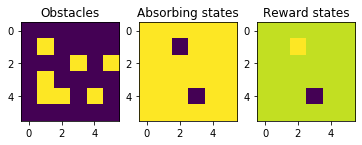

In [250]:
### Define the grid
print("Creating the Grid world, represented as:\n")
grid = GridWorld()
# policy_indexed = np.random.randint(0, 4, size=(29,1))
# initState = (0,0)
# final_grid,_ = grid.generate_final_grid()
# Trace = grid.generate_trace(policy_indexed, initState, final_grid)





Its graphical representation is:



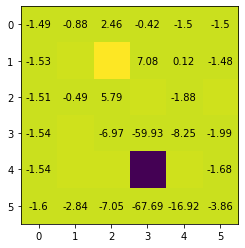

In [251]:
#Question 3 - first visit MC_pred - this needs work - also start plotting RMSE
numIterations = 1000
policy_indexed = np.random.randint(0, 4, size=(29,1))
alpha = 0.1
MC_val = grid.first_visit_MC_pred(numIterations, policy_indexed, alpha )

MC_vals = MC_val.ravel()
# print(MC_vals)
# MC_vals = np.delete(MC_vals, [7,15,17,19,25,26,28])


# print("\n\nThe value of that policy is:\n\n {}".format(MC_vals))
print("\n\nIts graphical representation is:\n")
grid.draw_value(MC_vals)      


In [217]:
#SARSA algorithm
episodes = 1000
epsilon = 0.1
alpha = 0.1
policy = np.zeros((29,4))
Q, policy_indexed,reward_agent_final =  grid.SARSA_learning_TD_function(alpha, epsilon, episodes)


-23
mean -74.58358358358359
standard deviation 71.60118365132689

Reward of agent vs the number of episodes:



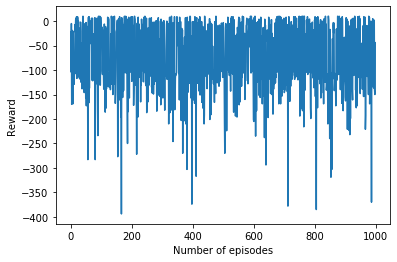

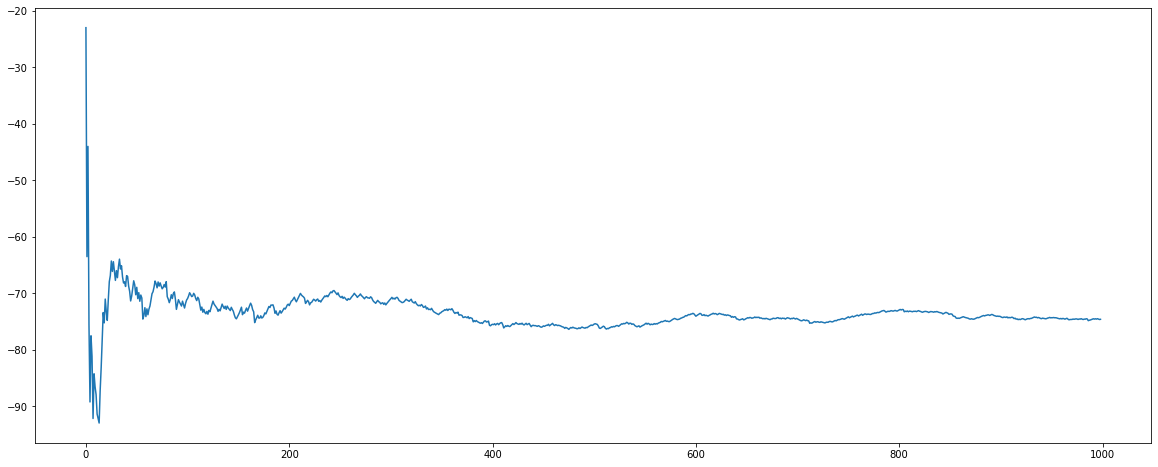

In [218]:
#assessing the learning rate
reward_agent_final = np.array(reward_agent_final)
reward_agent_final = np.delete(reward_agent_final, 0)
print(reward_agent_final[0])
print('mean',np.mean(reward_agent_final))
print('standard deviation',np.std(reward_agent_final))

# l = [x for x in reward_agent_final if -3 < x <= 2]
# l
no_eps = list(range(len(reward_agent_final)))
# Plot the reward of the agent vs episodes
print("\nReward of agent vs the number of episodes:\n")
plt.figure()
plt.plot(no_eps, reward_agent_final)
plt.xlabel("Number of episodes")
plt.ylabel("Reward")
plt.show()

T = [reward_agent_final[0]]
# print(T)
# print(reward_agent_final)
for k in range(1,len(reward_agent_final)):
    r = (reward_agent_final[k]+k*T[k-1])/(k+1)
    T.append(r)
plt.figure(figsize = (20,8))
plt.plot(T)


[[ -1.5123603   -1.50074243  -1.52076596  -1.50302473]
 [ -1.03084048  -1.27219123  -1.22924356  -1.382976  ]
 [  1.41438879   2.07665972   1.4926799    0.61115486]
 [ -0.76520477  -0.90442318  -0.94099504  -0.7077478 ]
 [ -1.41220255  -1.44598231  -1.43555799  -1.43548686]
 [ -1.52298303  -1.52471806  -1.52337081  -1.52478126]
 [ -1.53073284  -1.53140243  -1.53205117  -1.53397501]
 [  0.           0.           0.           0.        ]
 [  1.03471888   2.10445443   2.2485677    0.05521232]
 [ -1.18078696  -1.33732619  -1.38190729  -1.27986892]
 [ -1.51351552  -1.51065692  -1.49646387  -1.51105218]
 [ -1.50238806  -1.50731969  -1.50435972  -1.51932694]
 [ -1.1535147   -1.23589425  -1.3659625   -0.9823226 ]
 [  6.14364986   1.5400229    2.23689965   2.00371693]
 [ -1.72584737  -1.65884527  -1.79473084  -1.87054895]
 [ -1.53583643  -1.53698353  -1.5360652   -1.53558692]
 [ -4.03163641  -2.68266684  -4.12182623  -3.23880258]
 [-23.38121682 -28.33420997 -29.1929217  -16.87040083]
 [ -2.6309

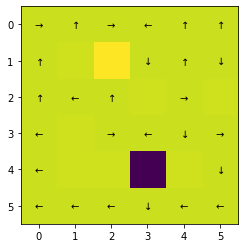

In [219]:
#Assessing the policy of TD - Q-learning
for i in range(len(policy_indexed)):
    policy[i] = grid.actions_indexed[int(policy_indexed[i])]
policy

print(Q)
#Plot policy for policy iteration

print("\n\nThe optimal policy using SARSA is:\n\n {}".format(policy))
print("\n\nIts graphical representation is:\n")
grid.draw_deterministic_policy(np.array([np.argmax(policy[row,:]) for row in range(grid.state_size)]))


In [220]:
#implement policy improvement MC 
episodes = 1000
epsilon = 0.1
alpha = 0.1
policy = np.zeros((29,4))
Q, policy_indexed,reward_agent_final = grid.monte_carlo_e_soft(episodes, epsilon, alpha)


mean -1.487438711520837
standard deviation 0.22373731164289187
Q function [[ -1.          -1.          -1.          -1.        ]
 [ -1.46656071  -1.44711491  -1.48876026  -1.43298617]
 [  0.59163523   2.80525087   1.1179856    0.49982847]
 [ -1.53602399  -1.53690604  -1.53597409  -1.53667245]
 [ -1.52181181  -1.53299938  -1.52280727  -1.5154293 ]
 [ -1.48557375  -1.45793973  -1.5130217   -1.44894046]
 [ -1.44643415  -1.46971493  -1.45197152  -1.44837784]
 [  0.           0.           0.           0.        ]
 [  4.27498185  -0.58274579   1.83666912   0.30331098]
 [ -1.52635862  -1.53254888  -1.51036654  -1.50722037]
 [ -1.49091537  -1.46599512  -1.47323722  -1.49091356]
 [ -1.51872809  -1.52880759  -1.52698448  -1.5261734 ]
 [ -1.53619122  -1.53783148  -1.53772597  -1.53755422]
 [  0.39433474   1.62435801   0.18173009   0.85852289]
 [ -1.51317131  -1.41574054  -1.46599747  -1.46599784]
 [ -1.53689886  -1.5364478   -1.53417637  -1.53663591]
 [ -1.51570397  -1.52630173  -1.52188328  -1.5

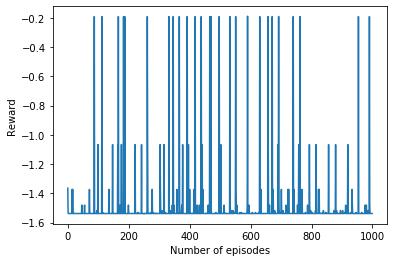

In [221]:
##Investigating the learning rate
reward_agent_final = np.array(reward_agent_final)

print('mean',np.mean(reward_agent_final))
print('standard deviation',np.std(reward_agent_final))
no_eps = list(range(episodes))
print('Q function',Q)
# print(reward_agent_final)
# l = [x for x in reward_agent_final if -3 < x <= 2]
# l
no_eps = list(range(len(reward_agent_final)))
#Plot the reward of the agent vs episodes
print("\nReward of agent vs the number of episodes:\n")
plt.figure()
plt.plot(no_eps, reward_agent_final)
plt.xlabel("Number of episodes")
plt.ylabel("Reward")
plt.show()


[[ -1.          -1.          -1.          -1.        ]
 [ -1.46656071  -1.44711491  -1.48876026  -1.43298617]
 [  0.59163523   2.80525087   1.1179856    0.49982847]
 [ -1.53602399  -1.53690604  -1.53597409  -1.53667245]
 [ -1.52181181  -1.53299938  -1.52280727  -1.5154293 ]
 [ -1.48557375  -1.45793973  -1.5130217   -1.44894046]
 [ -1.44643415  -1.46971493  -1.45197152  -1.44837784]
 [  0.           0.           0.           0.        ]
 [  4.27498185  -0.58274579   1.83666912   0.30331098]
 [ -1.52635862  -1.53254888  -1.51036654  -1.50722037]
 [ -1.49091537  -1.46599512  -1.47323722  -1.49091356]
 [ -1.51872809  -1.52880759  -1.52698448  -1.5261734 ]
 [ -1.53619122  -1.53783148  -1.53772597  -1.53755422]
 [  0.39433474   1.62435801   0.18173009   0.85852289]
 [ -1.51317131  -1.41574054  -1.46599747  -1.46599784]
 [ -1.53689886  -1.5364478   -1.53417637  -1.53663591]
 [ -1.51570397  -1.52630173  -1.52188328  -1.51571789]
 [-54.78966331 -27.67842049 -31.41956916 -25.21507583]
 [ -1.4390

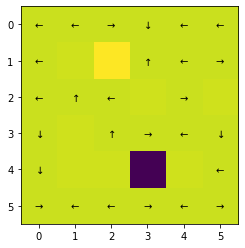

In [222]:
## MC assessing the policy chosen 
for i in range(len(policy_indexed)):
    policy[i] = grid.actions_indexed[int(policy_indexed[i])]
policy

print(Q)
# print(policy)
# Plot policy for policy iteration
print("\n\nThe optimal policy using policy iteration is:\n\n {}".format(policy))
print("\n\nIts graphical representation is:\n")
grid.draw_deterministic_policy(np.array([np.argmax(policy[row,:]) for row in range(grid.state_size)]))

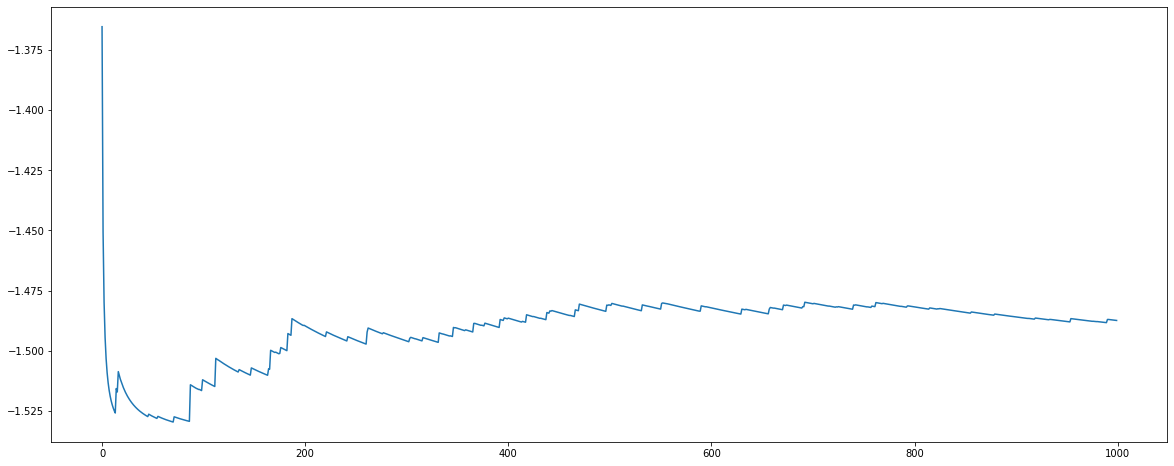

In [223]:
# Assessing the learning rate as a running mean
T = [reward_agent_final[0]]
# print(T)
# print(reward_agent_final)
for k in range(1,len(reward_agent_final)):
    r = (reward_agent_final[k]+k*T[k-1])/(k+1)
    T.append(r)
plt.figure(figsize = (20,8))
plt.plot(T)


In [224]:
# TD learning - implement Q-learning algorithm 
episodes = 100
epsilon = 0.1
alpha = 0.1
policy = np.zeros((29,4))
Q, policy_indexed,reward_agent_final =  grid.Q_learning_TD_function(alpha, epsilon, episodes)


-101
mean -66.52525252525253
standard deviation 71.62322057787077

Reward of agent vs the number of episodes:



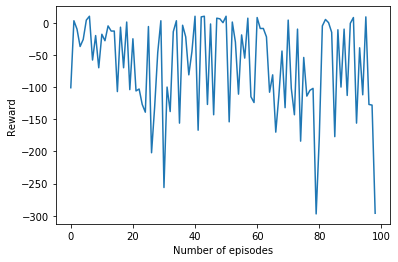

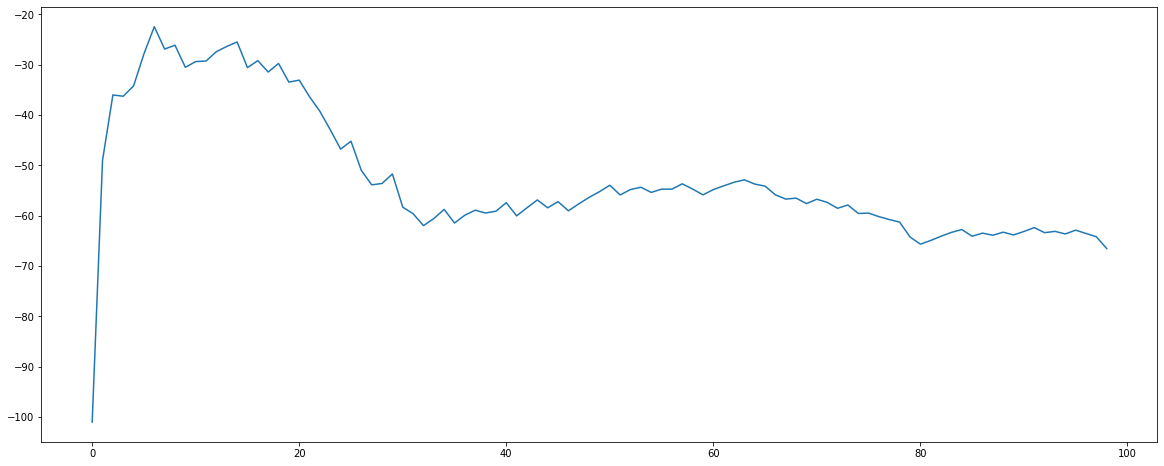

In [225]:
#assessing the learning rate
reward_agent_final = np.array(reward_agent_final)
reward_agent_final = np.delete(reward_agent_final, 0)
print(reward_agent_final[0])
print('mean',np.mean(reward_agent_final))
print('standard deviation',np.std(reward_agent_final))

# l = [x for x in reward_agent_final if -3 < x <= 2]
# l
no_eps = list(range(len(reward_agent_final)))
# Plot the reward of the agent vs episodes
print("\nReward of agent vs the number of episodes:\n")
plt.figure()
plt.plot(no_eps, reward_agent_final)
plt.xlabel("Number of episodes")
plt.ylabel("Reward")
plt.show()

T = [reward_agent_final[0]]
# print(T)
# print(reward_agent_final)
for k in range(1,len(reward_agent_final)):
    r = (reward_agent_final[k]+k*T[k-1])/(k+1)
    T.append(r)
plt.figure(figsize = (20,8))
plt.plot(T)


[[ -0.55096955  -0.33505635  -0.41551646  -0.40290848]
 [ -0.43991552  -0.32545648  -0.41130476  -0.35726165]
 [  3.43396293   1.18888121   3.66345002   3.92853398]
 [ -0.20387151  -0.34086679  -0.16956434  -0.31565208]
 [ -0.31749269  -0.30265963  -0.3065729   -0.18560341]
 [ -0.41968873  -0.36605723  -0.26059989  -0.28870911]
 [ -0.57907743  -0.3263377   -0.44185922  -0.42814523]
 [  0.           0.           0.           0.        ]
 [  2.34669034   2.31550732   1.65185979  -0.26332719]
 [ -0.35835881  -0.42554198  -0.28764699  -0.22053917]
 [ -0.27346553  -0.29633048  -0.3857531   -0.36079413]
 [ -0.57754465  -0.43749883  -0.53615056  -0.56037747]
 [ -0.50413247  -0.34899769  -0.40542053  -0.4600256 ]
 [  0.89045928   2.24758217   0.08552026   3.43383937]
 [ -0.41004336  -0.27763534  -0.22272302  -0.30025797]
 [ -0.47476799  -0.51957646  -0.44625152  -0.48223907]
 [ -0.15653825  -0.08192345  -0.10837123  -0.0881384 ]
 [-41.33747119  -4.99546151 -15.99257298 -17.00741072]
 [ -0.3540

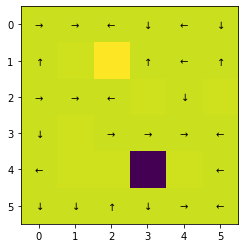

In [226]:
#Assessing the policy of TD - Q-learning
for i in range(len(policy_indexed)):
    policy[i] = grid.actions_indexed[int(policy_indexed[i])]
policy

print(Q)
#Plot policy for policy iteration

print("\n\nThe optimal policy using Q-learning is:\n\n {}".format(policy))
print("\n\nIts graphical representation is:\n")
grid.draw_deterministic_policy(np.array([np.argmax(policy[row,:]) for row in range(grid.state_size)]))





The value of that policy is:

 [ -1.51518487  -1.32812867   2.79225975  -0.73073929  -1.48304019
  -1.52663222  -1.52938499   0.           0.06395753  -1.43296948
  -1.52640919  -1.51584061  -1.33597436   1.60902637  -1.96709809
  -1.53568133  -6.10157348 -41.10975491  -6.18506465  -1.80996682
  -1.54249516   0.          -1.61528678  -1.65458953  -2.09069067
  -3.8284893  -24.23150558  -4.94726348  -2.50645682]


Its graphical representation is:



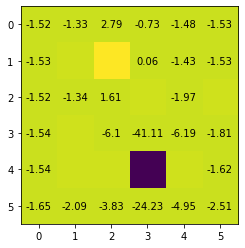

In [242]:
# #Question 4 - TD value estimation
episodes= 1000
policy_indexed = np.random.randint(0, 4, size=(29,1))
alpha = 0.1
TD_val = grid.TD_value_estimation(episodes, policy_indexed,alpha)
TD_vals = TD_val.ravel()


print("\n\nThe value of that policy is:\n\n {}".format(TD_vals))
print("\n\nIts graphical representation is:\n")
grid.draw_value(TD_vals)            


Considering the uniform (unbiased) policy:

 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


The value of that policy is:

 [ -1.5005629   -1.18913235   1.71689631  -0.90637264  -1.45047078
  -1.52583824  -1.53103802   0.           1.70951816  -1.26623906
  -1.50816477  -1.5071122   -1.2230007    1.40352556  -1.79449067
  -1.53535149  -4.14114386 -29.02140661  -4.22616075  -1

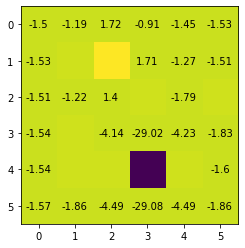


It took 9 epochs



In [176]:
### Question 1: study of a uniform policy

# Plot policy
gamma = 0.35
Policy = np.zeros((grid.state_size, grid.action_size))
Policy = Policy + 0.25
print("Considering the uniform (unbiased) policy:\n\n {}".format(Policy))
# Do not plot a graphical representation for this policy as it is fully random

# Policy evaluation for gamma = 0.9
val, epochs = grid.policy_evaluation(Policy, 0.001, gamma)

# Plot value function
print("\n\nThe value of that policy is:\n\n {}".format(val))
print("\n\nIts graphical representation is:\n")
grid.draw_value(val)

# Plot number of epochs
print("\nIt took {} epochs\n".format(epochs))
#type(val)

The value of the optimal policy computed using policy iteration is:

 [ -2.65386158   0.19930718   4.45902423   1.2251276   -1.83188779
  -3.57830993  -4.27903779   0.           4.05051489  -1.66168597
  -3.50358604  -4.3511173   -1.91460696   1.54957404  -6.44162836
  -6.15800278  -9.91512976 -32.79742234 -14.02472296 -12.65431711
  -7.63742269   0.         -12.75885477  -9.28386107 -12.17908156
 -19.18037751 -38.28346872 -20.48643338 -14.50103501]


Its graphical representation is:



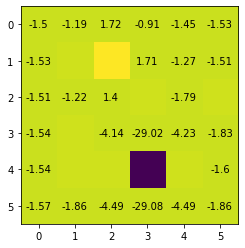



The optimal policy using policy iteration is:

 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


Its graphical representation is:



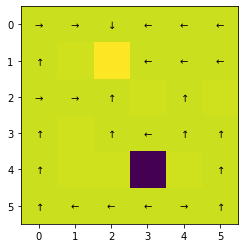


It took 205 epochs



In [177]:
### Question 2 to 6:

# Policy iteration algorithm
V_opt, pol_opt, epochs = grid.policy_iteration()

# Plot value function for policy iteration
print("The value of the optimal policy computed using policy iteration is:\n\n {}".format(V_opt))
print("\n\nIts graphical representation is:\n")
grid.draw_value(val)

# Plot policy for policy iteration
print("\n\nThe optimal policy using policy iteration is:\n\n {}".format(pol_opt))
print("\n\nIts graphical representation is:\n")
grid.draw_deterministic_policy(np.array([np.argmax(pol_opt[row,:]) for row in range(grid.state_size)]))

# Plot number of epochs
print("\nIt took {} epochs\n".format(epochs))


Impact of gamma value on the number of epochs needed for the policy iteration algorithm:



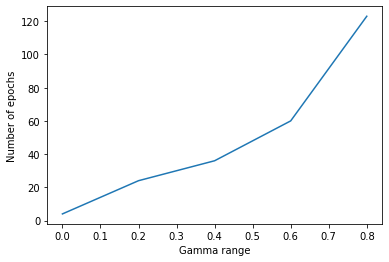


Graphical representation of the value function for each gamma:



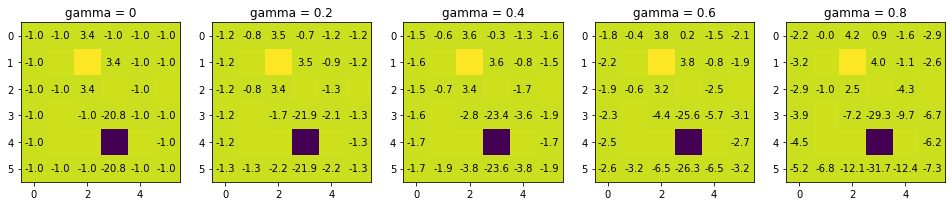


Graphical representation of the policy for each gamma:



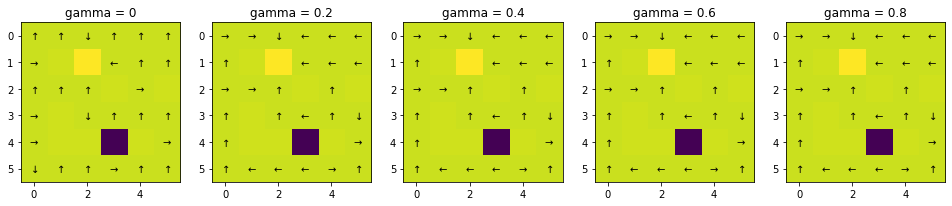

In [39]:
# Impact of gamma on the policy iteration algorithm

gamma_range = [0, 0.2, 0.4, 0.6, 0.8]
epochs_needed = []
pols_needed = []
vals_needed = []
titles = []

# Use policy iteration for each gamma value
for gamma in gamma_range:
    V_opt, pol_opt, epochs = grid.policy_iteration(discount = gamma)
    epochs_needed.append(epochs)
    pols_needed.append(np.array([np.argmax(pol_opt[row,:]) for row in range(grid.state_size)]))
    vals_needed.append(V_opt)
    titles.append("gamma = {}".format(gamma))

# Plot the number of epochs vs gamma values
print("\nImpact of gamma value on the number of epochs needed for the policy iteration algorithm:\n")
plt.figure()
plt.plot(gamma_range, epochs_needed)
plt.xlabel("Gamma range")
plt.ylabel("Number of epochs")
plt.show()

# Print all value functions and policies for different values of gamma
print("\nGraphical representation of the value function for each gamma:\n")
grid.draw_value_grid(vals_needed, titles, 1, 6)

print("\nGraphical representation of the policy for each gamma:\n")
grid.draw_deterministic_policy_grid(pols_needed, titles, 1, 6)

The optimal policy computed using value iteration is:

 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


Its graphical representation is:



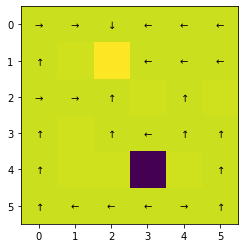


It took 50 epochs



In [40]:
# Value iteration algorithm
pol_opt2, epochs = grid.value_iteration()

# Plot policy for policy iteration
print("The optimal policy computed using value iteration is:\n\n {}".format(pol_opt2))
print("\n\nIts graphical representation is:\n")
grid.draw_deterministic_policy(np.array([np.argmax(pol_opt2[row,:]) for row in range(grid.state_size)]))

# Plot number of epoch
print("\nIt took {} epochs\n".format(epochs))


Impact of gamma value on the number of epochs needed for the value iteration algorithm:



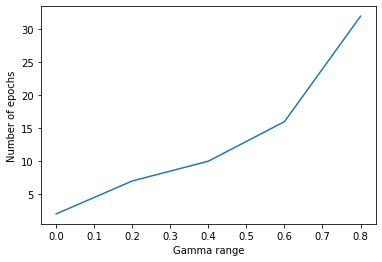


Graphical representation of the policy for each gamma:



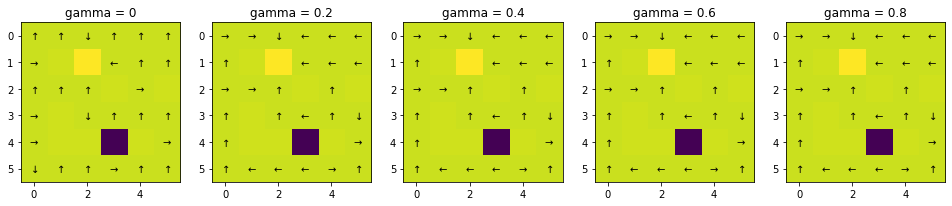

In [41]:
# Impact of gamma on the value iteration algorithm
gamma_range = [0, 0.2, 0.4, 0.6, 0.8]
epochs_needed = []
pols_needed = []
pols_title = []

# Use value iteration for each gamma value
for gamma in gamma_range:
    pol_opt2, epochs = grid.value_iteration(discount = gamma)
    epochs_needed.append(epochs)
    pols_needed.append(np.array([np.argmax(pol_opt2[row,:]) for row in range(grid.state_size)]))
    pols_title.append("gamma = {}".format(gamma))

# Plot the number of epochs vs gamma values
print("\nImpact of gamma value on the number of epochs needed for the value iteration algorithm:\n")
plt.figure()
plt.plot(gamma_range, epochs_needed)
plt.xlabel("Gamma range")
plt.ylabel("Number of epochs")
plt.show()

# Print all policies for different values of gamma
print("\nGraphical representation of the policy for each gamma:\n")
grid.draw_deterministic_policy_grid(pols_needed, pols_title, 1, 6)


Impact of gamma value on the number of epochs needed for the policy evaluation algorithm:



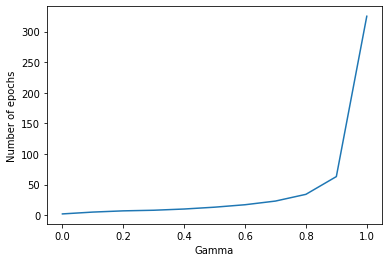


Graphical representation of the value function for each gamma:



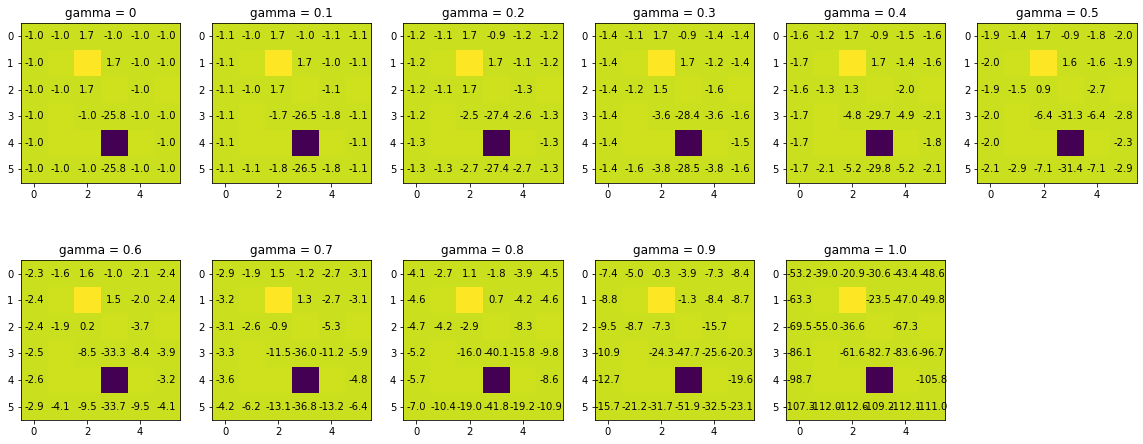

In [42]:
# Impact of gamma on the uniform policy evaluation
#Part 4 of question 2 - also do something similar for p
gamma_range = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
epochs_needed = []
vals_needed = []
vals_title = []

# Use policy evaluation for each gamma value
for gamma in gamma_range:
    val, epochs = grid.policy_evaluation(Policy, 0.001, gamma)
    epochs_needed.append(epochs)
    vals_needed.append(val)
    vals_title.append("gamma = {}".format(gamma))

# Plot the number of epochs vs gamma values
print("\nImpact of gamma value on the number of epochs needed for the policy evaluation algorithm:\n")
plt.figure()
plt.plot(gamma_range, epochs_needed)
plt.xlabel("Gamma")
plt.ylabel("Number of epochs")
plt.show()

# Print all value functions for different values of gamma
print("\nGraphical representation of the value function for each gamma:\n")
grid.draw_value_grid(vals_needed, vals_title, 2, 6)